# Import

In [57]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
# append utils env path
sys.path.append("../../Utils/tfrecord/image")
from tfrecord_utils import image2tfrecord
from tfrecord_preprocess import get_training_dataset, BATCH_SIZE
import efficientnet.tfkeras as efn

# Configs

In [33]:
CONFIGS = {
    "IMAGE_DIR": "../SampleData",
    "TFRECORD_DIR": "../SampleDataTFR"
}

# Define ArcMarginProduct

In [2]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False, ls_eps=0.0, **kwargs):
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

        
    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(tf.math.l2_normalize(X, axis=1), tf.math.l2_normalize(self.W, axis=0))
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
            
        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes), dtype=cosine.dtype)
        
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

# Image processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


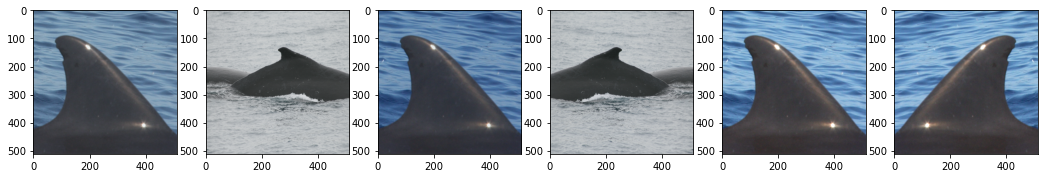

In [41]:
# to tfrecord
image2tfrecord(
    CONFIGS["IMAGE_DIR"],
    CONFIGS["TFRECORD_DIR"]
)

filenames = [os.path.join(tfrecord_dir, filename) for filename in os.listdir(tfrecord_dir) if "tfrecord" in filename]
dataset = get_training_dataset(filenames)

fig = plt.figure(figsize=(18, 8))
batch_imgs = []
batch_labels = []
for index, data in enumerate(dataset):
    for b_i, b in enumerate(range(BATCH_SIZE)):
        ax = fig.add_subplot(1, 6, index * BATCH_SIZE + b_i + 1)
        ax.imshow(data[0]["input/image"][b])
        batch_imgs.append(data[0]["input/image"])
        batch_labels.append(data[1])
    if index == 2:
        break
plt.show()


# Define layers

In [36]:
backbone = efn.EfficientNetB5(include_top=False, weights='noisy-student')
backbone.trainable=True
pooling = tf.keras.layers.GlobalAveragePooling2D(name='head/pooling')
dropout = tf.keras.layers.Dropout(0.3, name='head/dropout')
dense = tf.keras.layers.Dense(512, name='head/dense')
dense

# Stacking / get margins

In [54]:
x = backbone(batch_imgs[0])
x = pooling(x)
embeded = dropout(x)
margin = ArcMarginProduct(
        n_classes=2,
        s=30,
        m=0.3,
        name='head/arc_margin',
        dtype='float32'
)
margin_result = margin([embeded, batch_labels[0]])
margin_result

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-9.251312  , -1.1320013 ],
       [-0.72764534, -9.157398  ]], dtype=float32)>

In [56]:
margin.W.shape

TensorShape([2048, 2])

In [52]:
batch_labels[0]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1])>